In [1]:
from importlib import reload
import matplotlib.pyplot as plt
from scipy import spatial
import numpy as np
from scipy.linalg import eig, eigh

import merger_tree_tools as mtt
import snapshot_tools as st
import halo_tools as ht
import galaxy_tools as gt
from time import sleep, perf_counter

from halomod import TracerHaloModel
import halomod
import hmf

In [2]:
mtt=reload(mtt)
st=reload(st)
ht=reload(ht)

In [3]:
snap=st.SnapshotTools('/fred/oz009/cpower/L125_N512_2LPT/HiSURFS_L125_0076/HiSURFS_L125_0076','HDF5', convention='SWIFT',positions_only=False)
halo=ht.HaloTools('/fred/oz009/cpower/L125_N512_2LPT/halos/HiSURFS_L125_0076.VELOCIraptor','VELOCIraptor')
halo1=ht.HaloTools('/fred/oz009/cpower/L125_N512_2LPT/halos/HiSURFS_L125_0076.VELOCIraptor','VELOCIraptor')
halo2=ht.HaloTools('/fred/oz009/cpower/L125_N512_2LPT/halos_2382023/HiSURFS_L125_0076.VELOCIraptor','VELOCIraptor')
# halo3=ht.HaloTools('/fred/oz009/cpower/L125_N512_2LPT/halos_new/HiSURFS_L125_0076.VELOCIraptor','VELOCIraptor')
# halo4=ht.HaloTools('/fred/oz009/cpower/L125_N512_2LPT/halos_old/HiSURFS_L125_0076.VELOCIraptor','VELOCIraptor')
tree=mtt.TreeTools('/fred/oz009/cpower/L125_N512_2LPT/trees/VELOCIraptor.walkabletree.forestID.hdf5.0','TreeFrog')

snap.ReadSnapshot()
halo.ReadHaloCatalogue()
halo1.ReadHaloCatalogue()
halo2.ReadHaloCatalogue()
# halo3.ReadHaloCatalogue()
# halo4.ReadHaloCatalogue()
tree.ReadMergerTreeCatalogue()

Reading data from /fred/oz009/cpower/L125_N512_2LPT/HiSURFS_L125_0076/HiSURFS_L125_0076.hdf5
Simulation scale factor: 1.000000
Number of particles: 0134217728
Number of particle types: 7
Reading data for 148501 groups
['File_id', 'Group_Size', 'Num_of_files', 'Num_of_groups', 'Number_of_substructures_in_halo', 'Offset', 'Offset_unbound', 'Parent_halo_ID', 'Total_num_of_groups']
Reading data for 148501 groups
Reading data for 49658411 particles in groups
Reading data for 4843005 particles in groups
Reading data for 148501 groups
['File_id', 'Group_Size', 'Num_of_files', 'Num_of_groups', 'Number_of_substructures_in_halo', 'Offset', 'Offset_unbound', 'Parent_halo_ID', 'Total_num_of_groups']
Reading data for 148501 groups
Reading data for 49658411 particles in groups
Reading data for 4843005 particles in groups
Reading data for 124324 groups
['File_id', 'Group_Size', 'Num_of_files', 'Num_of_groups', 'Number_of_substructures_in_halo', 'Offset', 'Offset_unbound', 'Parent_halo_ID', 'Total_num

In [4]:
import h5py

file_path = '/fred/oz009/cpower/L125_N512_2LPT/halos/HiSURFS_L125_0076.VELOCIraptor.properties.0'

# 打开 HDF 文件
with h5py.File(file_path, 'r') as file:
    # 列出文件中的所有数据集
    def print_hdf5_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name} - Shape: {obj.shape} - Data Type: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"Group: {name}")

    file.visititems(print_hdf5_structure)


Group: Configuration
Dataset: Efrac - Shape: (148501,) - Data Type: float64
Dataset: Efrac_gas - Shape: (148501,) - Data Type: float64
Dataset: Efrac_star - Shape: (148501,) - Data Type: float64
Dataset: Ekin - Shape: (148501,) - Data Type: float64
Dataset: Epot - Shape: (148501,) - Data Type: float64
Dataset: File_id - Shape: (1,) - Data Type: int32
Dataset: ID - Shape: (148501,) - Data Type: uint64
Dataset: ID_mbp - Shape: (148501,) - Data Type: int64
Dataset: ID_mbp_bh - Shape: (148501,) - Data Type: int64
Dataset: ID_minpot - Shape: (148501,) - Data Type: int64
Dataset: Krot - Shape: (148501,) - Data Type: float64
Dataset: Krot_gas - Shape: (148501,) - Data Type: float64
Dataset: Krot_gas_nsf - Shape: (148501,) - Data Type: float64
Dataset: Krot_gas_sf - Shape: (148501,) - Data Type: float64
Dataset: Krot_star - Shape: (148501,) - Data Type: float64
Dataset: Lx - Shape: (148501,) - Data Type: float64
Dataset: Lx_200c_excl_gas - Shape: (148501,) - Data Type: float64
Dataset: Lx_200c

In [5]:
final_snap_num=76
halo_list=np.logical_and(halo1.Structuretype==10,halo1.GroupMFOF>snap.Particle_mass*600)

main_subhalo_list=halo1.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

NumGroups=main_subhalo_list.size
print(NumGroups)

halo1_m200=np.zeros(NumGroups)
veldisp1_sub=np.zeros(NumGroups)

G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo1.GroupID)[0]
    # print(halo_id, main_halo, final_snap_num)
    redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
    if len(mass)>0:
        # assemble history
        # formation_redshift[ihalo]=zform
        # alpha03[ihalo]=alpha

        # general properties
        # halo_masstot[ihalo]=mass[0]
        halo1_m200[ihalo]=m200[0]

        subhalo_ids = np.where(halo_id+1==halo1.ParentHaloID)#[0]
        for subhalo_id in subhalo_ids:
            if len(halo1.GroupM200[subhalo_id]) > 2:
                # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
                # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
                # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
                # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
                # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
                veldisp1_sub[ihalo] = np.linalg.norm(np.std(halo1.GroupVel[subhalo_id],axis=0))
                # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
            else:
                # m200_sub[ihalo] = 0  
                # Vmax_sub[ihalo] = 0
                veldisp1_sub[ihalo] = 0

    ihalo+=1

print(halo1_m200,veldisp1_sub)

Tracking merger histories for 8682 halos
8682
[4.40996065e+04 4.24301593e+04 1.02335680e+04 ... 3.37217031e+01
 3.53003391e+01 3.18102098e+01] [1175.98364741 1161.98804245  944.86180759 ...    0.            0.
    0.        ]


In [6]:
final_snap_num=76
halo_list=np.logical_and(halo2.Structuretype==10,halo2.GroupMFOF>snap.Particle_mass*600)

main_subhalo_list=halo2.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

NumGroups=main_subhalo_list.size
print(NumGroups)

halo2_m200=np.zeros(NumGroups)
veldisp2_sub=np.zeros(NumGroups)

G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo2.GroupID)[0]
    # print(halo_id, main_halo, final_snap_num)
    redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
    if len(mass)>0:
        # assemble history
        # formation_redshift[ihalo]=zform
        # alpha03[ihalo]=alpha

        # general properties
        # halo_masstot[ihalo]=mass[0]
        halo2_m200[ihalo]=m200[0]

        subhalo_ids = np.where(halo_id+1==halo2.ParentHaloID)#[0]
        for subhalo_id in subhalo_ids:
            if len(halo2.GroupM200[subhalo_id]) > 2:
                # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
                # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
                # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
                # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
                # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
                veldisp2_sub[ihalo] = np.linalg.norm(np.std(halo2.GroupVel[subhalo_id],axis=0))
                # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
            else:
                # m200_sub[ihalo] = 0  
                # Vmax_sub[ihalo] = 0
                veldisp2_sub[ihalo] = 0

    ihalo+=1

print(halo2_m200,veldisp2_sub)

Tracking merger histories for 9155 halos
9155
[4.40996065e+04 4.24301593e+04 1.02335680e+04 ... 3.05100474e+01
 3.30968595e+01 3.20129504e+01] [1290.11524899 1242.60350912 1006.89051056 ...    0.            0.
    0.        ]


In [7]:
# final_snap_num=76
# halo_list=np.logical_and(halo3.Structuretype==10,halo3.GroupMFOF>snap.Particle_mass*600)

# main_subhalo_list=halo3.GroupID[halo_list]
# print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

# NumGroups=main_subhalo_list.size
# print(NumGroups)

# halo3_m200=np.zeros(NumGroups)
# veldisp3_sub=np.zeros(NumGroups)

# G=43
# ihalo=0
# for main_halo in main_subhalo_list:
#     halo_id=np.where(main_halo==halo3.GroupID)[0]
#     # print(halo_id, main_halo, final_snap_num)
#     redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
#     if len(mass)>0:
#         # assemble history
#         # formation_redshift[ihalo]=zform
#         # alpha03[ihalo]=alpha

#         # general properties
#         # halo_masstot[ihalo]=mass[0]
#         halo3_m200[ihalo]=m200[0]

#         subhalo_ids = np.where(halo_id+1==halo3.ParentHaloID)#[0]
#         for subhalo_id in subhalo_ids:
#             if len(halo3.GroupM200[subhalo_id]) > 2:
#                 # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
#                 # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
#                 # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
#                 # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
#                 # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
#                 veldisp3_sub[ihalo] = np.linalg.norm(np.std(halo3.GroupVel[subhalo_id],axis=0))
#                 # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
#             else:
#                 # m200_sub[ihalo] = 0  
#                 # Vmax_sub[ihalo] = 0
#                 veldisp3_sub[ihalo] = 0

#     ihalo+=1

# print(halo3_m200,veldisp3_sub)

In [8]:
# final_snap_num=76
# halo_list=np.logical_and(halo4.Structuretype==10,halo4.GroupMFOF>snap.Particle_mass*600)

# main_subhalo_list=halo4.GroupID[halo_list]
# print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

# NumGroups=main_subhalo_list.size
# print(NumGroups)

# halo4_m200=np.zeros(NumGroups)
# veldisp4_sub=np.zeros(NumGroups)

# G=43
# ihalo=0
# for main_halo in main_subhalo_list:
#     halo_id=np.where(main_halo==halo4.GroupID)[0]
#     # print(halo_id, main_halo, final_snap_num)
#     redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
#     if len(mass)>0:
#         # assemble history
#         # formation_redshift[ihalo]=zform
#         # alpha03[ihalo]=alpha

#         # general properties
#         # halo_masstot[ihalo]=mass[0]
#         halo4_m200[ihalo]=m200[0]

#         subhalo_ids = np.where(halo_id+1==halo4.ParentHaloID)#[0]
#         for subhalo_id in subhalo_ids:
#             if len(halo4.GroupM200[subhalo_id]) > 2:
#                 # m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
#                 # mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
#                 # mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
#                 # mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
#                 # Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
#                 veldisp4_sub[ihalo] = np.linalg.norm(np.std(halo4.GroupVel[subhalo_id],axis=0))
#                 # vel_sub[ihalo] = np.std(halo.GroupVel[subhalo_id])
#             else:
#                 # m200_sub[ihalo] = 0  
#                 # Vmax_sub[ihalo] = 0
#                 veldisp4_sub[ihalo] = 0

#     ihalo+=1

# print(halo4_m200,veldisp4_sub)

/tmp/ipykernel_3358401/2161623795.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo1_m200)+10, np.log10(veldisp1_sub), s=2, color='r')
/tmp/ipykernel_3358401/2161623795.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(halo2_m200)+10, np.log10(veldisp2_sub), s=2, color='b')


Text(0, 0.5, '$Log_{10}~\\sigma$ [km s$^{-1}$]')

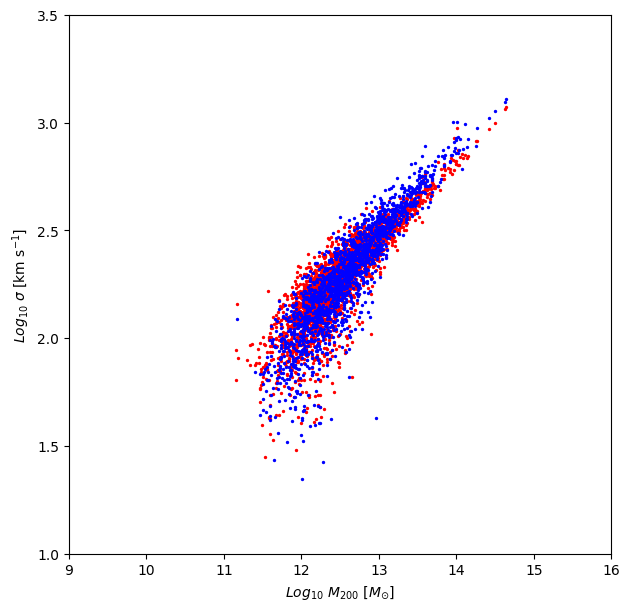

In [9]:
fig=plt.figure(figsize=(7,7))
ax=fig.add_subplot(1,1,1)
# for idx, (dataset, color, label) in enumerate(zip(datasets, colors, labels), start=1):
    # ax.scatter(np.log10(dataset[:, 1])+10, np.log10(dataset[:, 34]**2*dataset[:,5]/43/dataset[:, 1]), s=2, color=color)
ax.scatter(np.log10(halo1_m200)+10, np.log10(veldisp1_sub), s=2, color='r')
ax.scatter(np.log10(halo2_m200)+10, np.log10(veldisp2_sub), s=2, color='b')
# ax.scatter(np.log10(halo3_m200)+10, np.log10(veldisp3_sub), s=2, color='g')
# ax.scatter(np.log10(halo4_m200)+10, np.log10(veldisp4_sub), s=2, color='pink')
# plt.plot(best_fit_x, best_fit_y, color='red', label='Linear Fit')  
plt.ylim(1,3.5) 
plt.xlim(9,16) 
# ax.text(9.6,3.3,'All halos', size=16, color='black')
# ax.text(9.6,3.1,'subhalos', size=16, color='purple')
# ax.text(9.6, 2.9, f'slope={slope:.3f}', size=16, color='red')
ax.set_xlabel(r'$Log_{10}~M_{200}~[M_{\odot}]$')
ax.set_ylabel(r'$Log_{10}~\sigma$ [km s$^{-1}$]')

In [10]:
final_snap_num=76
halo_list=np.logical_and(halo.Structuretype==10,halo.GroupMFOF>snap.Particle_mass*600)

main_subhalo_list=halo.GroupID[halo_list]
print("Tracking merger histories for %04d halos"%main_subhalo_list.size)

start_time=perf_counter()

kdtree=spatial.KDTree(snap.pos,compact_nodes=True, copy_data=False, balanced_tree=True,leafsize=10,boxsize=1.001*snap.BoxSize)

end_time=perf_counter()
print(f'It took {end_time-start_time:0.2f} seconds (s)')

Tracking merger histories for 8682 halos
It took 51.69 seconds (s)


In [23]:
start_time=perf_counter()

NumGroups=main_subhalo_list.size

formation_redshift=np.zeros(NumGroups)
alpha03=np.zeros(NumGroups)

Nsub=np.zeros(NumGroups)
HostID=np.zeros(NumGroups)
msub=np.zeros(NumGroups)
frac=np.zeros(NumGroups)

veldisp_3D_sub=np.zeros(NumGroups)
veldisp_1D_sub=np.zeros(NumGroups)

halo_masstot=np.zeros(NumGroups)
halo_m200=np.zeros(NumGroups)
halo_mvir=np.zeros(NumGroups)
halo_mfof=np.zeros(NumGroups)

offset=np.zeros(NumGroups)
number=np.zeros(NumGroups)
r200=np.zeros(NumGroups)
rvir=np.zeros(NumGroups)

Ekin=np.zeros(NumGroups)
Epot=np.zeros(NumGroups)
eta=np.zeros(NumGroups)
angular_momentum=np.zeros(NumGroups)
spin=np.zeros(NumGroups)

veldisp_3d=np.zeros(NumGroups)
veldisp_1d=np.zeros(NumGroups)

veldisp_random_1d=np.zeros(NumGroups)
random_veldisp = np.zeros((NumGroups, 10)) 

siga=np.zeros(NumGroups)
sigb=np.zeros(NumGroups)
sigc=np.zeros(NumGroups)
sigv=np.zeros(NumGroups)
c_a=np.zeros(NumGroups)
b_a=np.zeros(NumGroups)

particle_mass=np.zeros(NumGroups)
boxsize=np.zeros(NumGroups)

Nsub=np.zeros(NumGroups)
m200_sub=np.zeros(NumGroups)
mtot_sub=np.zeros(NumGroups)
mvir_sub=np.zeros(NumGroups)
mfof_sub=np.zeros(NumGroups)

veldisp_sub=np.zeros(NumGroups)
veldisp_submbp=np.zeros(NumGroups)
veldisp_subminpot=np.zeros(NumGroups)
Vmax=np.zeros(NumGroups)
Vmax_sub=np.zeros(NumGroups)
frac=np.zeros(NumGroups)
frac_v=np.zeros(NumGroups)
major_merger=np.zeros(NumGroups)
max_mass=np.zeros(NumGroups)
max_redshift=np.zeros(NumGroups)

def find_most_massive_merger(redshift, mass):
    sorted_indices = np.argsort(mass)[::-1]
    sorted_redshift = redshift[sorted_indices]
    sorted_mass = mass[sorted_indices]
    max_massive_diff = 0
    max_massive_redshift = None
    for i in range(len(sorted_mass) - 1):
        massive_diff = sorted_mass[i] - sorted_mass[i+1]
        if massive_diff > max_massive_diff:
            max_massive_diff = massive_diff
            max_massive_redshift = sorted_redshift[i]
    return max_massive_redshift

def find_max_mass_redshift(redshift, mass):
    valid_indices = redshift < 0.5
    valid_redshift = redshift[valid_indices]
    valid_mass = mass[valid_indices]
    
    sorted_indices = np.argsort(valid_mass)[::-1]
    sorted_mass = valid_mass[sorted_indices]
    
    max_mass = 0
    max_redshift = None
    
    for i in range(len(sorted_mass) - 1):
        gai = (sorted_mass[i] - sorted_mass[i+1]) / sorted_mass[i]
        if gai > max_mass:
            max_mass = gai
            max_redshift = valid_redshift[sorted_indices[i]]
    
    return max_mass, max_redshift


radius_list = [1.0, 2.5, 5.0]
rho_results = np.zeros((NumGroups,len(radius_list)))

G=43
ihalo=0
for main_halo in main_subhalo_list:
    halo_id=np.where(main_halo==halo.GroupID)[0]
    # print(halo_id, main_halo, final_snap_num)
    redshift,mass,m200,group_number,subhalo_number,zform,alpha=tree.TrackMainHaloProgenitor(main_halo,final_snap_num)
    
    if len(mass)>0:
        # assemble history
        formation_redshift[ihalo]=zform
        alpha03[ihalo]=alpha

        # general properties
        halo_masstot[ihalo]=mass[0]
        halo_m200[ihalo]=m200[0]
        halo_mvir[ihalo]=halo.GroupMvir[halo_id]
        halo_mfof[ihalo]=halo.GroupMFOF[halo_id]

        number[ihalo] = halo.GroupLen[halo_id]
        particle_mass[ihalo] = snap.Particle_mass
        boxsize[ihalo] = snap.BoxSize

        rhalo=halo.GroupR200[halo_id]

        r200[ihalo]=halo.GroupR200[halo_id]
        rvir[ihalo]=halo.GroupRvir[halo_id]
        Ekin[ihalo] = halo.Ekin[halo_id]
        Epot[ihalo] = halo.Epot[halo_id]
        eta[ihalo] = 2 * Ekin[ihalo] / abs(Epot[ihalo]) if Epot[ihalo] != 0 else float('inf')
        angular_momentum[ihalo] = np.linalg.norm([halo.Lx[halo_id], halo.Ly[halo_id], halo.Lz[halo_id]])
        spin[ihalo] = angular_momentum[ihalo] * np.sqrt(np.abs(Ekin[ihalo]+Epot[ihalo])) / (G * halo_m200[ihalo]**2.5)

        c_a[ihalo] = halo.Minor_axis_ratio[halo_id]
        b_a[ihalo] = halo.semi_major_axis_ratio[halo_id]
    
        # Centre of halo
        pos_halo=halo.GroupPos[halo_id]
        pids=kdtree.query_ball_point(pos_halo,r=rhalo)[0]#,return_sorted=True)#,return_length=True)    
        dr=snap.pos[pids]-halo.GroupPos[halo_id]
        dr[:,0]=np.where(dr[:,0]>0.5*snap.BoxSize,dr[:,0]-snap.BoxSize,dr[:,0])
        dr[:,0]=np.where(dr[:,0]<-0.5*snap.BoxSize,dr[:,0]+snap.BoxSize,dr[:,0])
        dr[:,1]=np.where(dr[:,1]>0.5*snap.BoxSize,dr[:,1]-snap.BoxSize,dr[:,1])
        dr[:,1]=np.where(dr[:,1]<-0.5*snap.BoxSize,dr[:,1]+snap.BoxSize,dr[:,1])
        dr[:,2]=np.where(dr[:,2]>0.5*snap.BoxSize,dr[:,2]-snap.BoxSize,dr[:,2])
        dr[:,2]=np.where(dr[:,2]<-0.5*snap.BoxSize,dr[:,2]+snap.BoxSize,dr[:,2])

        r=np.sqrt(dr[:,0]**2+dr[:,1]**2+dr[:,2]**2)
        indx=np.where(r<rhalo)[0]

        xc=np.sum(snap.pos[pids][indx][:,0])/snap.pos[pids][indx][:,0].size
        yc=np.sum(snap.pos[pids][indx][:,1])/snap.pos[pids][indx][:,1].size
        zc=np.sum(snap.pos[pids][indx][:,2])/snap.pos[pids][indx][:,2].size

        d=halo.GroupPos[halo_id]-np.array([xc,yc,zc]).T
        d[:,0]=np.where(d[:,0]>0.5*snap.BoxSize,d[:,0]-snap.BoxSize,d[:,0])
        d[:,0]=np.where(d[:,0]<-0.5*snap.BoxSize,d[:,0]+snap.BoxSize,d[:,0])
        d[:,1]=np.where(d[:,1]>0.5*snap.BoxSize,d[:,1]-snap.BoxSize,d[:,1])
        d[:,1]=np.where(d[:,1]<-0.5*snap.BoxSize,d[:,1]+snap.BoxSize,d[:,1])
        d[:,2]=np.where(d[:,2]>0.5*snap.BoxSize,d[:,2]-snap.BoxSize,d[:,2])
        d[:,2]=np.where(d[:,2]<-0.5*snap.BoxSize,d[:,2]+snap.BoxSize,d[:,2])

        diff=np.sqrt(d[:,0]**2+d[:,1]**2+d[:,2]**2)
        offset[ihalo]=diff/halo.GroupR200[halo_id]

        # velocity dispersion
        xx = halo.xx[halo_id]
        xy = halo.xy[halo_id]
        xz = halo.xz[halo_id]
        yx = halo.yx[halo_id]
        yy = halo.yy[halo_id]
        yz = halo.yz[halo_id]
        zx = halo.zx[halo_id]
        zy = halo.zy[halo_id]
        zz = halo.zz[halo_id]
        inertia_tensor = np.array([[xx, xy, xz],
                                   [yx, yy, yz],
                                   [zx, zy, zz]])
        inertia_tensor = np.squeeze(inertia_tensor)
    
        veldisp_xx = halo.veldisp_xx[halo_id]
        veldisp_xy = halo.veldisp_xy[halo_id]
        veldisp_xz = halo.veldisp_xz[halo_id]
        veldisp_yx = halo.veldisp_yx[halo_id]
        veldisp_yy = halo.veldisp_yy[halo_id]
        veldisp_yz = halo.veldisp_yz[halo_id]
        veldisp_zx = halo.veldisp_zx[halo_id]
        veldisp_zy = halo.veldisp_zy[halo_id]
        veldisp_zz = halo.veldisp_zz[halo_id]
        veldisp_matrix = np.array([[veldisp_xx, veldisp_xy, veldisp_xz],
                                   [veldisp_yx, veldisp_yy, veldisp_yz],
                                   [veldisp_zx, veldisp_zy, veldisp_zz]])
        veldisp_matrix = np.squeeze(veldisp_matrix)
        
        eigenvalues_inertia, _ = eigh(inertia_tensor)
        eigenvalues_veldisp, _ = eigh(veldisp_matrix)
    
        veldisp_3d[ihalo] = np.linalg.norm(np.sqrt(np.abs(eigenvalues_veldisp)))
        veldisp_1d[ihalo] = veldisp_3d[ihalo] / np.sqrt(3)
        
        sorted_indices = np.argsort(np.abs(eigenvalues_veldisp))[::-1]
        veldisp_x = np.sqrt(np.abs(eigenvalues_veldisp[sorted_indices[0]]))
        veldisp_y = np.sqrt(np.abs(eigenvalues_veldisp[sorted_indices[1]]))
        veldisp_z = np.sqrt(np.abs(eigenvalues_veldisp[sorted_indices[2]]))
    
        siga[ihalo] = veldisp_x
        sigb[ihalo] = veldisp_y
        sigc[ihalo] = veldisp_z
        sigv[ihalo] = halo.sigV[halo_id]

        # random 1d velocity disoersion
        random_direction = np.random.normal(size=3)
        random_direction /= np.linalg.norm(random_direction)  
        veldisp_random = np.dot(random_direction.T, np.dot(veldisp_matrix, random_direction))
        veldisp_random_1d[ihalo] = np.sqrt(np.abs(veldisp_random))
        
        random_veldisp1d=[]
        for _ in range(10):
            random_direction = np.random.normal(size=3)
            random_direction /= np.linalg.norm(random_direction)  # Normalize to a unit vector
            veldisp_random = np.dot(random_direction.T, np.dot(veldisp_matrix, random_direction))
            random_veldisp1d.append(np.sqrt(np.abs(veldisp_random)))
        random_veldisp[ihalo,:] = np.array(random_veldisp1d)

        # properties of subhalos
        Nsub[ihalo] = halo.GroupNsubs[halo_id]
        Vmax[ihalo] = halo.Vmax[halo_id]
        subhalo_ids = np.where(halo_id+1==halo.ParentHaloID)#[0]
        for subhalo_id in subhalo_ids:
            if len(halo.GroupM200[subhalo_id]) > 2:
                m200_sub[ihalo] = np.max(halo.GroupM200[subhalo_id])
                mvir_sub[ihalo] = np.max(halo.GroupMvir[subhalo_id])
                mtot_sub[ihalo] = np.max(halo.GroupMass[subhalo_id])
                mfof_sub[ihalo] = np.max(halo.GroupMFOF[subhalo_id])
                
                Vmax_sub[ihalo] = np.max(halo.Vmax[subhalo_id])
                veldisp_sub[ihalo] = np.linalg.norm(np.std(halo.GroupVel[subhalo_id],axis=0))
                # veldisp_submbp[ihalo] = np.linalg.norm(np.std(halo.GroupVelmbp[subhalo_id],axis=0))
                # veldisp_subminpot[ihalo] = np.linalg.norm(np.std(halo.GroupVelminpot[subhalo_id],axis=0))
            else:
                m200_sub[ihalo] = 0  
                Vmax_sub[ihalo] = 0
                veldisp_sub[ihalo] = 0
                # veldisp_submbp[ihalo] = 0
                # veldisp_subminpot[ihalo] = 0
    
        frac[ihalo] = m200_sub[ihalo]/halo_m200[ihalo]
        frac_v[ihalo] = Vmax_sub[ihalo]/Vmax[ihalo]
        major_merger[ihalo] = find_most_massive_merger(redshift, m200)
        max_mass[ihalo], max_redshift[ihalo] = find_max_mass_redshift(redshift, m200)
        
    ihalo+=1

end_time=perf_counter()
print(f'It took {end_time-start_time:0.2f} seconds (s)')  

It took 128.20 seconds (s)


/tmp/ipykernel_3358401/3181406372.py:3: RuntimeWarning: invalid value encountered in true_divide
  data1 = veldisp_1d / veldisp_3d * np.sqrt(3)
/tmp/ipykernel_3358401/3181406372.py:6: RuntimeWarning: invalid value encountered in true_divide
  data2 = siga / veldisp_3d * np.sqrt(3)
/tmp/ipykernel_3358401/3181406372.py:9: RuntimeWarning: invalid value encountered in true_divide
  data3 = sigb / veldisp_3d * np.sqrt(3)
/tmp/ipykernel_3358401/3181406372.py:12: RuntimeWarning: invalid value encountered in true_divide
  data4 = sigc / veldisp_3d * np.sqrt(3)
/tmp/ipykernel_3358401/3181406372.py:15: RuntimeWarning: invalid value encountered in true_divide
  data5 = veldisp_random_1d / veldisp_3d * np.sqrt(3)
/tmp/ipykernel_3358401/3181406372.py:19: RuntimeWarning: invalid value encountered in true_divide
  random_veldisp_normalized = random_veldisp / veldisp_3d[:, np.newaxis] * np.sqrt(3)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore ar

Text(0, 0.5, 'The number of halo')

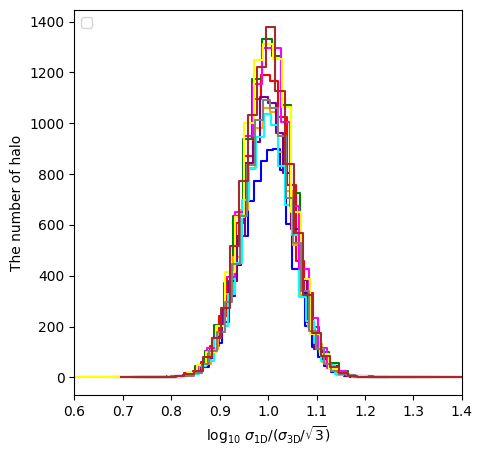

In [38]:
import numpy as np

data1 = veldisp_1d / veldisp_3d * np.sqrt(3)
data1 = data1[np.isfinite(data1)] 

data2 = siga / veldisp_3d * np.sqrt(3)
data2 = data2[np.isfinite(data2)]

data3 = sigb / veldisp_3d * np.sqrt(3)
data3 = data3[np.isfinite(data3)]

data4 = sigc / veldisp_3d * np.sqrt(3)
data4 = data4[np.isfinite(data4)]

data5 = veldisp_random_1d / veldisp_3d * np.sqrt(3)
data5 = data5[np.isfinite(data5)]

# random_veldisp_normalized = random_veldisp / veldisp_3d * np.sqrt(3)
random_veldisp_normalized = random_veldisp / veldisp_3d[:, np.newaxis] * np.sqrt(3)
random_veldisp_normalized = random_veldisp_normalized[np.isfinite(random_veldisp_normalized).all(axis=1)]

# print(data1,data2,data3,data4,data5)

hist3, bins3 = np.histogram(data1, bins=40)
hist4, bins4 = np.histogram(data2, bins=40)
hist5, bins5 = np.histogram(data3, bins=40)
hist6, bins6 = np.histogram(data4, bins=40)
hist7, bins7 = np.histogram(data5, bins=40)

fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(1,1,1)

# ax.step(bins3[:-1], hist3, where='post', color='black', label='Line of sight')
# ax.step(bins4[:-1], hist4, where='post', color='r', label='major axis')
# ax.step(bins5[:-1], hist5, where='post', color='b', label='intermediate axis')
# ax.step(bins6[:-1], hist6, where='post', color='g', label='minor axis')
# ax.step(bins7[:-1], hist7, where='post', color='pink', label='random')

# 绘制 random_veldisp 的每一列的分布
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'gray', 'brown']
labels = [f"Random direction {i+1}" for i in range(10)]

for i in range(10):
    data = random_veldisp_normalized[:, i]
    hist, bins = np.histogram(data, bins=40)
    ax.step(bins[:-1], hist, where='post', color=colors[i])
        # 累计频率
    if total_hist is None:
        total_hist = hist
    else:
        total_hist += hist

# 绘制累计分布
# ax.step(bins[:-1], total_hist, where='post', color='black', label='Sum of distributions')

# plt.ylim(0,30000)
plt.xlim(0.6,1.4)
plt.legend(loc='upper left')
# plt.yscale('log')
ax.set_xlabel(r"log$_{10}~\sigma_{\rm 1D}/(\sigma_{\rm 3D}/\sqrt{3})$")
ax.set_ylabel(r"The number of halo")